In [1]:
#Run to start
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'

import sys
sys.path.insert(0,curr_dir)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import scipy.stats as stats
import scipy
import statsmodels.api as s
from sklearn import metrics

import pdb
import ptoc_params as params

from plotnine import *
#from plotnine import ggplot, aes, geom_point

#hide warnings
import warnings
warnings.filterwarnings('ignore')

#load additional libraries
from nilearn import image, plotting, input_data, glm
from nilearn.input_data import NiftiMasker
import nibabel as nib
import statsmodels.api as sm
from nilearn.datasets import load_mni152_brain_mask, load_mni152_template

data_dir = params.data_dir
results_dir = params.results_dir
fig_dir = params.fig_dir
raw_dir = params.raw_dir

sub_info = params.sub_info
task_info = params.task_info

suf = params.suf
rois = params.rois
hemis = params.hemis

#load subject info
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')

#mni = load_mni152_brain_mask()

'''exp info'''
subs = ['sub-064']  # Run for one subject initially
#subs = sub_info['sub'].tolist()

#Just controls
subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()
study = 'ptoc'
data_dir = 'hemispace'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
out_dir = f'{study_dir}/derivatives/fc'
results_dir = '/user_data/csimmon2/GitHub_Repos/ptoc/results'
exp = ''
rois = ['LO']  # Run for one ROI initially
control_tasks = ['loc']
file_suf = ''

'''scan params'''
#tr = 1 #in the original code
#vols = 321 #in the original code

tr = 2 #ptoc_params
vols = 184 #ptoc_params

whole_brain_mask = load_mni152_brain_mask()
mni = load_mni152_template()
brain_masker = NiftiMasker(whole_brain_mask, smoothing_fwhm=0, standardize=True)

'''run info'''
run_num =3
runs = list(range(1,run_num+1))
run_combos = []
#determine the number of left out run combos
for rn1 in range(1,run_num+1):
    for rn2 in range(rn1+1,run_num+1):
        run_combos.append([rn1,rn2])

In [2]:
#ROI Coords
def extract_roi_coords():
    """
    Define ROIs
    """
    parcels = ['V1', 'aIPS', 'PFS', 'pIPS', 'LO']
    subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()

    for ss in subs:
        print(f'Processing subject: {ss}')
        sub_dir = f'{study_dir}/{ss}/ses-01'
        roi_dir = f'{sub_dir}/derivatives/rois'
        os.makedirs(f'{roi_dir}/spheres', exist_ok=True)
        
        exp_dir = f'{sub_dir}/derivatives/fsl'
        parcel_dir = f'{roi_dir}/parcels'
        roi_coords = pd.DataFrame(columns=['index', 'task', 'roi', 'x', 'y', 'z'])
        
        for rcn, rc in enumerate(run_combos):
            roi_runs = [ele for ele in runs if ele not in rc]
            
            #load each run
            all_runs = []
            for rn in roi_runs:
                curr_run_path = f'{exp_dir}/loc/run-0{rn}/1stLevel.feat/stats/zstat3_reg.nii.gz'
                if os.path.exists(curr_run_path):
                    curr_run = image.load_img(curr_run_path)
                    all_runs.append(curr_run)
                else:
                    print(f'File does not exist: {curr_run_path}')
            
            mean_zstat = image.mean_img(all_runs)
            affine = mean_zstat.affine

            for pr in parcels:
                roi_path = f'{parcel_dir}/{pr}.nii.gz'
                if os.path.exists(roi_path):
                    roi = image.load_img(roi_path)
                    roi = image.math_img('img > 0', img=roi)

                    coords = plotting.find_xyz_cut_coords(mean_zstat, mask_img=roi, activation_threshold=0.99)
                    
                    masked_stat = image.math_img('img1 * img2', img1=roi, img2=mean_zstat)
                    masked_stat = image.get_data(masked_stat)
                    np_coords = np.where(masked_stat == np.max(masked_stat))
                    
                    curr_coords = pd.Series([rcn, 'loc', pr] + coords, index=roi_coords.columns)
                    roi_coords = roi_coords.append(curr_coords, ignore_index=True)

                    # control task ROI
                    control_zstat_path = f'{exp_dir}/loc/HighLevel.gfeat/cope3.feat/stats/zstat1.nii.gz'
                    if os.path.exists(control_zstat_path):
                        control_zstat = image.load_img(control_zstat_path)
                        coords = plotting.find_xyz_cut_coords(control_zstat, mask_img=roi, activation_threshold=0.99)
                        
                        curr_coords = pd.Series([rcn, 'highlevel', pr] + coords, index=roi_coords.columns)
                        roi_coords = roi_coords.append(curr_coords, ignore_index=True)
                    else:
                        print(f'File does not exist: {control_zstat_path}')
                else:
                    print(f'File does not exist: {roi_path}')
            
        roi_coords.to_csv(f'{roi_dir}/spheres/sphere_coords.csv', index=False)

# Call the function
#extract_roi_coords()

In [3]:
# ROI Sphere and Psy Cov

#PHYS
def extract_roi_sphere(img, coords):
    roi_masker = input_data.NiftiSpheresMasker([tuple(coords)], radius = 6)
    seed_time_series = roi_masker.fit_transform(img)
    
    phys = np.mean(seed_time_series, axis= 1)
    #phys = (phys - np.mean(phys)) / np.std(phys) #TRY WITHOUT STANDARDIZING AT SOME POINT
    phys = phys.reshape((phys.shape[0],1))
    
    return phys
#extract_roi_sphere (img, coords)

#PSY
ss = '064'
runs = [1,2,3]
def make_psy_cov(runs,ss):
    #rois = ['LO']
    #tsk = 'loc'
    #rr = 'LO'
    #ss = '064'
    #runs = [1,2,3]
    vols = 184
    tr = 2
    
    raw_dir = params.raw_dir
    temp_dir = f'{raw_dir}/sub-{ss}/ses-01' #raw_dir is from hemispace
    cov_dir = f'{temp_dir}/covs'
    
    times = np.arange(0, vols*len(runs), tr)
    full_cov = pd.DataFrame(columns = ['onset','duration', 'value'])
    
    for rn, run in enumerate(runs):    
        
        curr_cov = pd.read_csv(f'{cov_dir}/catloc_{ss}_run-0{run}_Object.txt', sep = '\t', header = None, names = ['onset','duration', 'value'])
        curr_cov_path = f'{cov_dir}/catloc_{ss}_run-0{run}_Object.txt'
        print(f'Loaded curr_cov from: {curr_cov_path}')
        print(curr_cov)
        #contrasting (neg) cov

        curr_cont = pd.read_csv(f'{cov_dir}/catloc_{ss}_run-0{run}_Scramble.txt', sep = '\t', header =None, names =['onset','duration', 'value'])
        curr_cont_path = f'{cov_dir}/catloc_{ss}_run-0{run}_Scramble.txt'
        print(f'Loaded curr_cont from: {curr_cont_path}')
        print(curr_cont)
        curr_cont.iloc[:,2] = curr_cont.iloc[:,2] *-1 #make contrasting cov neg
        
        curr_cov = curr_cov.append(curr_cont) #append to positive

        curr_cov['onset'] = curr_cov['onset'] + (vols*rn) ##THIS IS THE PROBLEM I THINK
        #curr_cov['onset'] = curr_cov['onset'] + ((rn_n)*vols) ##alternative
        full_cov = full_cov.append(curr_cov)
        #add number of vols to the timing cols based on what run you are on
        #e.g., for run 1, add 0, for run 2, add 321
        #curr_cov['onset'] = curr_cov['onset'] + ((rn_n)*vols) 
        
        
        #append to concatenated cov
    full_cov = full_cov.sort_values(by =['onset'])
    cov = full_cov.to_numpy()

    #convolve to hrf
    psy, name = glm.first_level.compute_regressor(cov.T, 'spm', times)
        

    return psy
make_psy_cov(runs,ss)

Loaded curr_cov from: /lab_data/behrmannlab/vlad/hemispace/sub-064/ses-01/covs/catloc_064_run-01_Object.txt
     onset  duration  value
0   80.015        16    1.0
1  248.012        16    1.0
2  320.012        16    1.0
Loaded curr_cont from: /lab_data/behrmannlab/vlad/hemispace/sub-064/ses-01/covs/catloc_064_run-01_Scramble.txt
     onset  duration  value
0  128.009        16    1.0
1  272.010        16    1.0
2  344.009        16    1.0
Loaded curr_cov from: /lab_data/behrmannlab/vlad/hemispace/sub-064/ses-01/covs/catloc_064_run-02_Object.txt
     onset  duration  value
0   56.016        16    1.0
1  128.008        16    1.0
2  320.010        16    1.0
Loaded curr_cont from: /lab_data/behrmannlab/vlad/hemispace/sub-064/ses-01/covs/catloc_064_run-02_Scramble.txt
     onset  duration  value
0   32.009        16    1.0
1  224.013        16    1.0
2  296.007        16    1.0
Loaded curr_cov from: /lab_data/behrmannlab/vlad/hemispace/sub-064/ses-01/covs/catloc_064_run-03_Object.txt
     o

array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.0

In [ ]:
#CONDUCT PPI
#rois = ['LO']
#rr = 'LO'
#runs = [1] #maybe it is supposed to by [0,1,2]?
#rn = 1
subs = ['064']
ss = ['064']
tsk = 'loc'
tr = 2
vols = 184

def conduct_ppi():
    for ss in subs:
        print(ss)
        sub_dir = f'{study_dir}/sub-{ss}/ses-01/' #study is PTOC
        roi_dir = f'{sub_dir}/derivatives/rois' #rois in PTOC
        exp_dir = f'{sub_dir}/derivatives/fsl/{exp}' #PTOC
        
        raw_dir = params.raw_dir
        temp_dir = f'{raw_dir}/sub-{ss}/ses-01' #hemispace 
        cov_dir = f'{temp_dir}/covs' #hemispace

        roi_coords = pd.read_csv(f'{roi_dir}/spheres/sphere_coords.csv') #load ROI coordinates
                                
        for rr in rois:
            all_runs = [] #this will get filled with the data from each run
            
            for rcn, rc in enumerate(run_combos): #determine which runs to use
                curr_coords = roi_coords[(roi_coords['index'] == rcn) & (roi_coords['task'] ==tsk) & (roi_coords['roi'] ==rr)] 
                filtered_list = []
                for rn in rc:
                    print (rn)
                    run_path = f'{temp_dir}/derivatives/fsl/loc/run-0{rn}/1stLevel.feat/filtered_func_data_reg.nii.gz'

                    if os.path.exists(run_path):
                        curr_run = image.load_img(run_path) #load image data
                        affine = curr_run.affine
                        curr_run = image.clean_img(curr_run, standardize=True)
                        filtered_list.append(curr_run)
                        print(f'Loaded {run_path}')
                    else:
                        print(f"File {run_path} does not exist.")
                    
                img4d = image.concat_imgs(filtered_list)
                phys = extract_roi_sphere(img4d,curr_coords[['x','y','z']].values.tolist()[0]) #clarify which coords 
                
                #load behavioral data
                psy = make_psy_cov(rc, ss) #load psy covariates
                
                #combine phys (seed TS) and psy (task TS) into a regressor 
                confounds = pd.DataFrame(columns =['psy', 'phys'])
                confounds['psy'] = psy[:,0]
                confounds['phys'] =phys[:,0]

                #create PPI cov by multiply psy * phys 
                ppi = psy*phys
                ppi = ppi.reshape((ppi.shape[0],1))

                brain_time_series = brain_masker.fit_transform(img4d, confounds=[confounds]) #change this line to remove confounds 
                brain_time_series_4FC = brain_masker.fit_transform(img4d) #change this line to remove confounds

                #Correlate interaction term to TS for vox in the brain
                seed_to_voxel_correlations = (np.dot(brain_time_series.T, ppi) /
                                ppi.shape[0])
                print(ss, rr, tsk, seed_to_voxel_correlations.max())
                
                #Correlate interaction term to TS for vox in the brain
                seed_to_voxel_correlations = (np.dot(brain_time_series_4FC.T, psy) /
                                psy.shape[0])
                
                #transform correlation back to brain space
                seed_to_voxel_correlations = np.arctanh(seed_to_voxel_correlations)
                
                #transform correlation map back to brain
                seed_to_voxel_correlations_img = brain_masker.inverse_transform(seed_to_voxel_correlations.T)
                
                all_runs.append(seed_to_voxel_correlations_img)

            mean_fc = image.mean_img(all_runs)
                
            #nib.save(mean_fc, f'{out_dir}/{ss}_{rr}_ppi.nii.gz') #creates the summary file for the PPI analysis (stop here each seed region and the rest of the brain)
            #nib.save(mean_fc, f'{out_dir}/{ss}_{rr}_fc_4FC.nii.gz') #creates the summary file for the PSY analysis
            
conduct_ppi()

064
1
Loaded curr_cov from: /lab_data/behrmannlab/vlad/hemispace/sub-064/ses-01/covs/catloc_064_run-01_Object.txt
     onset  duration  value
0   80.015        16    1.0
1  248.012        16    1.0
2  320.012        16    1.0
Loaded curr_cont from: /lab_data/behrmannlab/vlad/hemispace/sub-064/ses-01/covs/catloc_064_run-01_Scramble.txt
     onset  duration  value
0  128.009        16    1.0
1  272.010        16    1.0
2  344.009        16    1.0
Loaded curr_cov from: /lab_data/behrmannlab/vlad/hemispace/sub-064/ses-01/covs/catloc_064_run-02_Object.txt
     onset  duration  value
0   56.016        16    1.0
1  128.008        16    1.0
2  320.010        16    1.0
Loaded curr_cont from: /lab_data/behrmannlab/vlad/hemispace/sub-064/ses-01/covs/catloc_064_run-02_Scramble.txt
     onset  duration  value
0   32.009        16    1.0
1  224.013        16    1.0
2  296.007        16    1.0
2
Loaded curr_cov from: /lab_data/behrmannlab/vlad/hemispace/sub-064/ses-01/covs/catloc_064_run-01_Object.tx

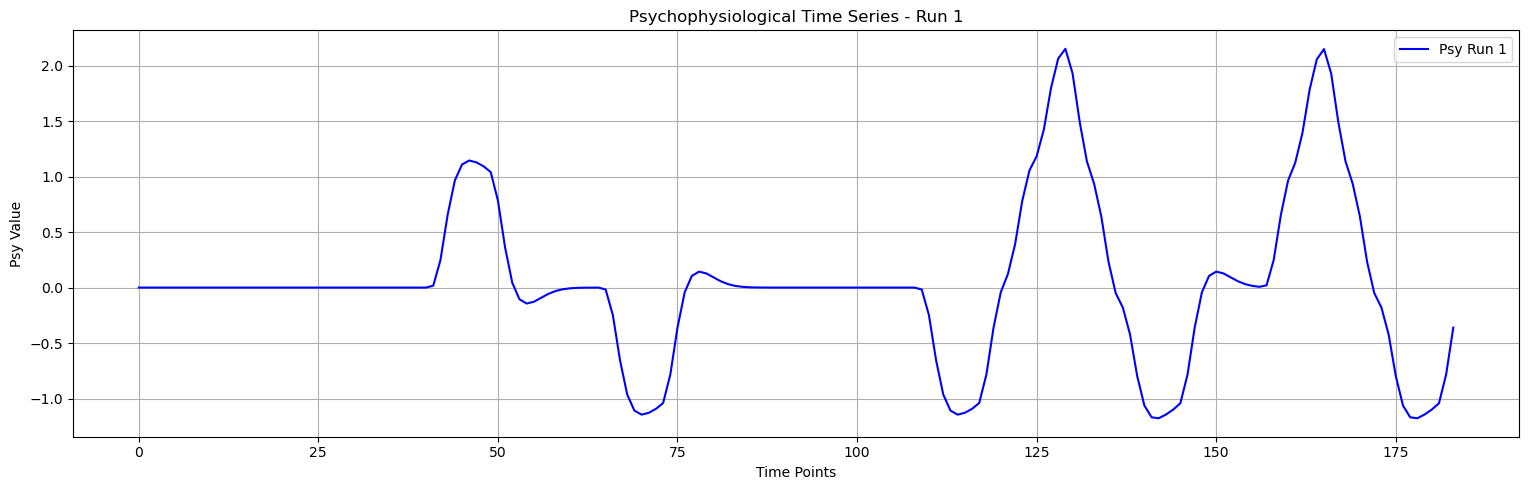

In [69]:
#Isolating psy
ss = '064'
tsk = 'loc'
tr = 2
vols = 184
rc = [1,2]

print(ss)
sub_dir = f'{study_dir}/sub-{ss}/ses-01/'
roi_dir = f'{sub_dir}/derivatives/rois'
exp_dir = f'{sub_dir}/derivatives/fsl/{exp}' 
raw_dir = params.raw_dir
temp_dir = f'{raw_dir}/sub-{ss}/ses-01' 
cov_dir = f'{temp_dir}/covs'
    
for rn in rc:
    print (rn)
    #load behavioral data
    psy = make_psy_cov(rc, ss) #load psy covariates
    
print (psy)

# plot psy
n_time_points = 184
n_runs = 1

print(f'psy shape: {psy.shape}')

# Plotting psy data for each run
plt.figure(figsize=(30, 5))

for run in range(n_runs):
    plt.subplot(n_runs, 2, run*2 + 1)
    plt.plot(np.arange(n_time_points), psy[:, run], label=f'Psy Run {run + 1}', color='blue')
    plt.xlabel('Time Points')
    plt.ylabel('Psy Value')
    plt.title(f'Psychophysiological Time Series - Run {run + 1}')
    plt.legend()
    plt.grid(True)

# Adjust layout and show plots
plt.tight_layout()
plt.show()


In [ ]:
#Isolating phys

# Constants and parameters
subs = ['064']
tsk = 'loc'
run_number = 1  # Specify the run number to process
roi_name = 'LO'

# Paths
#study_dir = '/path/to/study_dir'
#exp = 'experiment_name'  # Define this based on your setup
#raw_dir = '/path/to/raw_dir'  # Define the correct path

for ss in subs:
    print(f'Processing subject: {ss}')
    sub_dir = f'{study_dir}/sub-{ss}/ses-01/'  # study is PTOC
    roi_dir = f'{sub_dir}/derivatives/rois'  # rois in PTOC
    temp_dir = f'{raw_dir}/sub-{ss}/ses-01'  # hemispace
    cov_dir = f'{temp_dir}/covs'  # hemispace

    # Load ROI coordinates
    roi_coords = pd.read_csv(f'{roi_dir}/spheres/sphere_coords.csv')

    # Filter coordinates for the specific ROI and task
    curr_coords = roi_coords[(roi_coords['task'] == tsk) & (roi_coords['roi'] == roi_name)]

    # Process only the specified run
    run_path = f'{temp_dir}/derivatives/fsl/loc/run-0{run_number}/1stLevel.feat/filtered_func_data_reg.nii.gz'
    if os.path.exists(run_path):
        curr_run = image.load_img(run_path)  # Load image data
        print(f'Loaded run path: {run_path} with shape {curr_run.shape}')
        curr_run = image.clean_img(curr_run, standardize=True)

        # Extract ROI sphere using the first row of coordinates
        if not curr_coords.empty:
            coords = curr_coords[['x', 'y', 'z']].values[0].tolist()
            phys = extract_roi_sphere(curr_run, coords)
            print(f'Extracted phys data shape: {phys.shape} for ROI {roi_name} with coordinates {coords}')
        else:
            print(f'No coordinates found for ROI {roi_name} and task {tsk}')
    else:
        print(f"File {run_path} does not exist.")


In [ ]:
#plot phys
n_time_points = 184  # Number of time points per run
n_runs = 2  # Will be three after you run reg

# Plotting psy data for each run
plt.figure(figsize=(50, 5))

# Plotting phys data for each run
for run in range(n_runs):
    plt.subplot(n_runs, 2, run*2 + 2)
    plt.plot(np.arange(n_time_points), phys[:, run], label=f'Phys Run {run + 1}', color='green')
    plt.xlabel('Time Points')
    plt.ylabel('Phys Value')
    plt.title(f'Physiological Time Series - Run {run + 1}')
    plt.legend()
    plt.grid(True)

# Adjust layout and show plots
plt.tight_layout()
plt.show()

In [70]:
#MISSING FILES
tsk = 'loc'
tr = 2
vols = 184
sub_info = params.sub_info #load subject info
subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()
runs = [1,2,3]

for ss in subs:
    print(ss)
    raw_dir = params.raw_dir
    temp_dir = f'{raw_dir}/{ss}/ses-01' 
    cov_dir = f'{temp_dir}/covs'  
    for rn in runs:
        print (rn)
        run_path = f'{temp_dir}/derivatives/fsl/loc/run-0{rn}/1stLevel.feat/filtered_func_data_reg.nii.gz'
        if os.path.exists(run_path):
            print(f'File {run_path} exists')
        else:
            print(f"File {run_path} does not exist.")

sub-025
1
File /lab_data/behrmannlab/vlad/hemispace/sub-025/ses-01/derivatives/fsl/loc/run-01/1stLevel.feat/filtered_func_data_reg.nii.gz exists
2
File /lab_data/behrmannlab/vlad/hemispace/sub-025/ses-01/derivatives/fsl/loc/run-02/1stLevel.feat/filtered_func_data_reg.nii.gz exists
3
File /lab_data/behrmannlab/vlad/hemispace/sub-025/ses-01/derivatives/fsl/loc/run-03/1stLevel.feat/filtered_func_data_reg.nii.gz does not exist.
sub-038
1
File /lab_data/behrmannlab/vlad/hemispace/sub-038/ses-01/derivatives/fsl/loc/run-01/1stLevel.feat/filtered_func_data_reg.nii.gz exists
2
File /lab_data/behrmannlab/vlad/hemispace/sub-038/ses-01/derivatives/fsl/loc/run-02/1stLevel.feat/filtered_func_data_reg.nii.gz exists
3
File /lab_data/behrmannlab/vlad/hemispace/sub-038/ses-01/derivatives/fsl/loc/run-03/1stLevel.feat/filtered_func_data_reg.nii.gz does not exist.
sub-057
1
File /lab_data/behrmannlab/vlad/hemispace/sub-057/ses-01/derivatives/fsl/loc/run-01/1stLevel.feat/filtered_func_data_reg.nii.gz exists

In [ ]:
#pause before this section to review output with Vlad

def create_summary():
    ventral_rois = ['LO_toolloc']
    rois = ["PPC_spaceloc"]
    print(subs)
    
    for lrv in ['l', 'r']:
        for vr in ventral_rois:
            summary_df = pd.DataFrame(columns=['sub'] + ['l' + rr for rr in rois] + ['r' + rr for rr in rois])
            ventral = f'{lrv}{vr}'
            print(ventral)
            
            for ss in subs:
                sub_dir = f'{study_dir}/sub-{study}{ss}/ses-01/'
                roi_dir = f'{sub_dir}/derivatives/rois'
                
                ventral_mask = image.load_img(f'{roi_dir}/{ventral}.nii.gz')
                ventral_mask = NiftiMasker(ventral_mask)
                
                roi_mean = []
                roi_mean.append(ss)
                
                for lr in ['l', 'r']:
                    for rr in rois:
                        roi = f'{roi_dir}/{lr}{rr}.nii.gz'
                        fc_img = image.load_img(f'{out_dir}/sub-{study}{ss}_{lr}{rr}_ppi.nii.gz')
                        
                        mask_img = ventral_mask.fit_transform(fc_img)
                        mean_val = mask_img.mean()
                        roi_mean.append(mean_val)
                
                summary_df.loc[len(summary_df)] = roi_mean
            
            summary_df.to_csv(f'{results_dir}/ppi_summary_{ventral}.csv', index=False)
            
create_summary()

In [ ]:
#original with comments
#pause after this to check the output || run brain_time_series without confounds, and instead of ppi you would use phys || change the two lines to be the same, and then you can see the correlation between the two time series. || change the name of the output and the two lines 
def conduct_ppi():
    for ss in subs:
        print(ss)
        sub_dir = f'{study_dir}/sub-{study}{ss}/ses-01/'
        cov_dir = f'{sub_dir}/covs'
        roi_dir = f'{sub_dir}/derivatives/rois'
        exp_dir = f'{sub_dir}/derivatives/fsl/{exp}'

        roi_coords = pd.read_csv(f'{roi_dir}/spheres/sphere_coords.csv')

        for tsk in ['spaceloc','distloc']: #just include one task for now get rid of the loop and extract current coords
            for rr in rois:
                all_runs = [] #this will get filled with the data from each run
                for rcn, rc in enumerate(run_combos): #determine which runs to use for creating ROIs | run combos
                    curr_coords = roi_coords[(roi_coords['index'] == rcn) & (roi_coords['task'] ==tsk) & (roi_coords['roi'] ==rr)]

                    filtered_list = []
                    for rn in rc:
                        
                        curr_run = image.load_img(f'{exp_dir}/run-0{rn}/1stLevel.feat/filtered_func_data_reg.nii.gz') #filtered_func data - cope and zstat is a mean image, while the filtered is preprocessed data - standardized
                        #double check the above exists.
                        curr_run = image.clean_img(curr_run,standardize=True)
                        filtered_list.append(curr_run)
                        
                    img4d = image.concat_imgs(filtered_list)
                    phys = extract_roi_sphere(img4d,curr_coords[['x','y','z']].values.tolist()[0]) #extract ROI spehere coordinate, pulls out just the time series from that part of the brain, every voxel of the brain, time series for just the spheres we've pulled out
                    #load behavioral data
                    #CONVOLE TO HRF
                    psy = make_psy_cov(rc, ss) #this is the one that goes to the covariate folder and grabs the covariate we care about and converts the three coloumn into binary data. 

                    #combine phys (seed TS) and psy (task TS) into a regressor ||  TS = time series, CNS
                    confounds = pd.DataFrame(columns =['psy', 'phys'])
                    confounds['psy'] = psy[:,0]
                    confounds['phys'] =phys[:,0]

                    #create PPI cov by multiply psy * phys #this is createing the interaction term, the is the PPI time course. There are the individual, so we can get a brain time series with sine phys regressed out
                    ppi = psy*phys
                    ppi = ppi.reshape((ppi.shape[0],1))

                    brain_time_series = brain_masker.fit_transform(img4d, confounds=[confounds]) #change this line to remove confounds 
                    #brain_time_series_4FC = brain_masker.fit_transform(img4d) #change this line to remove confounds

                    #Correlate interaction term to TS for vox in the brain
                    seed_to_voxel_correlations = (np.dot(brain_time_series.T, ppi) /
                                    ppi.shape[0])
                    print(ss, rr, tsk, seed_to_voxel_correlations.max())
                    
                    #Correlate interaction term to TS for vox in the brain
                    #seed_to_voxel_correlations = (np.dot(brain_time_series_4FC.T, psy) /
                                    #psy.shape[0])
                    
                    seed_to_voxel_correlations = np.arctanh(seed_to_voxel_correlations) # transform back to brain space
                    #transform correlation map back to brain
                    seed_to_voxel_correlations_img = brain_masker.inverse_transform(seed_to_voxel_correlations.T)
                    
                    all_runs.append(seed_to_voxel_correlations_img)

                mean_fc = image.mean_img(all_runs)
                    
                nib.save(mean_fc, f'{out_dir}/sub-{study}{ss}_{rr}_{tsk}_ppi.nii.gz') #creates the summary file for the PPI analysis (stop here each seed region and the rest of the brain)
                #nib.save(mean_fc, f'{out_dir}/sub-{study}{ss}_{rr}_{tsk}_fc_4FC.nii.gz') #creates the summary file for the PSY analysis
